In [67]:
using Revise
using RxInfer, Random, Distributions, Plots, Flux, DelimitedFiles, StableRNGs
using ReactiveMP
using CCMP
using Base
using SpecialFunctions
using BenchmarkTools

In [68]:
# to check that matched with Semih
sunspot_semih = readdlm("data/SN_Akbayrak.csv")
semih_observations = map(Int, sunspot_semih[:,2]);

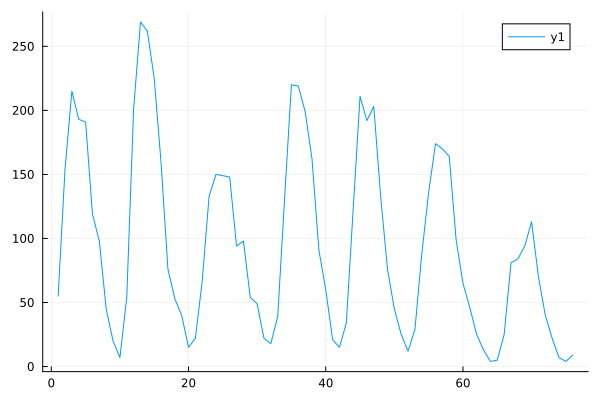

In [69]:
sunspot = readdlm("data/SN_y_tot_V2.0.csv", ';')
select_1945_2020 = filter((s) -> s[1] > 1945 && s[1] < 2021, collect(eachrow(sunspot)))
observations = map((s) -> round(s[2]), select_1945_2020)
@assert semih_observations == observations
plot(observations)


In [70]:
@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    identity() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(true), true)
end;

@model function sunspot_model(nr_observations)

    γ ~ GammaShapeRate(1000.0, 1)
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)
    
    # specify estimate of initial location
    z[1] ~ GammaShapeRate(1, γ)
    y[1] ~ Poisson(z[1])
    for t in 2:nr_observations
        # specify state transition model
        z[t] ~ GammaShapeRate(identity(z[t-1]), γ)
        y[t] ~ Poisson(z[t])
    end
end

@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    identity() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(true), false)
end;

@constraints function sunspot_constraints()
    q(γ, z) = q(γ)q(z)
    q(z) = q(z[begin])..q(z[end])
end;

@rule GammaShapeRate(:β, Marginalisation) (q_out::Gamma, q_α::SampleList, ) = begin 
    return GammaShapeRate(mean(q_α)+1, mean(q_out))
end

In [71]:
@average_energy GammaShapeRate (q_out::Any, q_α::SampleList, q_β::Any) = begin
    q_α_mean = mean(q_α)
    q_α_var = var(q_α)
    q_α_second_monement = q_α_var + q_α_mean^2
    q_α_matched = GammaShapeRate(q_α_second_monement/q_α_var, q_α_mean/q_α_var)
    mean(loggamma, q_α_matched) - mean(q_α) * mean(log, q_β) - (mean(q_α_matched) - 1.0) * mean(log, q_out) + mean(q_β) * mean(q_out)
end

In [75]:
# z_init = map(r -> NormalMeanPrecision(r, 10), 1:50)
nr_observations = length(observations)
results = inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1000, 10, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(1000.0, 1), z=Gamma(1000.0, 1))
)

Inference results:
  Posteriors       | available for (γ, z)
  Free Energy:     | Real[49086.3, 6971.84, 6951.62, 6953.33, 6955.34, 6956.59, 6956.22, 6954.77, 6955.72, 6955.18]


In [76]:
@benchmark inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1000, 10, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(1000.0, 1), z=Gamma(1000.0, 1))
)

BenchmarkTools.Trial: 21 samples with 1 evaluation.
 Range (min … max):  230.597 ms … 289.390 ms  ┊ GC (min … max): 6.30% … 17.69%
 Time  (median):     235.994 ms               ┊ GC (median):    6.26%
 Time  (mean ± σ):   240.343 ms ±  14.013 ms  ┊ GC (mean ± σ):  8.01% ±  3.11%

  █    ▃                                                         
  █▁▄▇▁█▁▄▇▁▁▁▁▁▁▄▁▄▁▁▁▁▁▁▁▁▁▄▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  231 ms           Histogram: frequency by time          289 ms <

 Memory estimate: 212.86 MiB, allocs estimate: 5737944.

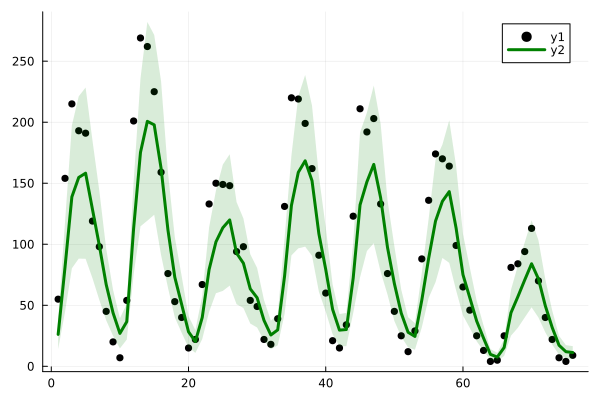

In [49]:
# plot estimates for location
posteriours = results.posteriors[:z][end]
means = map(mean, posteriours) 
ribbon = map(x -> var(x), posteriours)

p1 = scatter(observations,color=:black)

plot!(means, ribbon=ribbon, fillalpha=0.15, linewidth=3, color = :green)


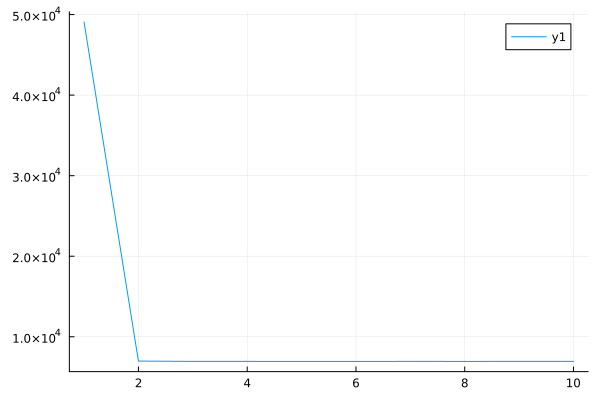

In [54]:
plot(results.free_energy[1:end])

In [25]:
open("estimations/cvi_sunspot_results.csv", "w") do io
    writedlm(io, [means ribbon])
end